# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [107]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *

## Visualize HW Behavior

In [108]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [109]:
guess_range=(0, 1e0)
# the number of guess values in the guess range
guess_val_size=1000
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 0.8890826472023605
print('secret_number =', secret_number)

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.8890826472023605


0.889    0.439679
0.890    0.308640
0.883    0.299211
0.888    0.288440
0.882    0.287614
0.884    0.283461
0.893    0.275899
0.892    0.270075
0.891    0.268225
0.885    0.264216
dtype: float64

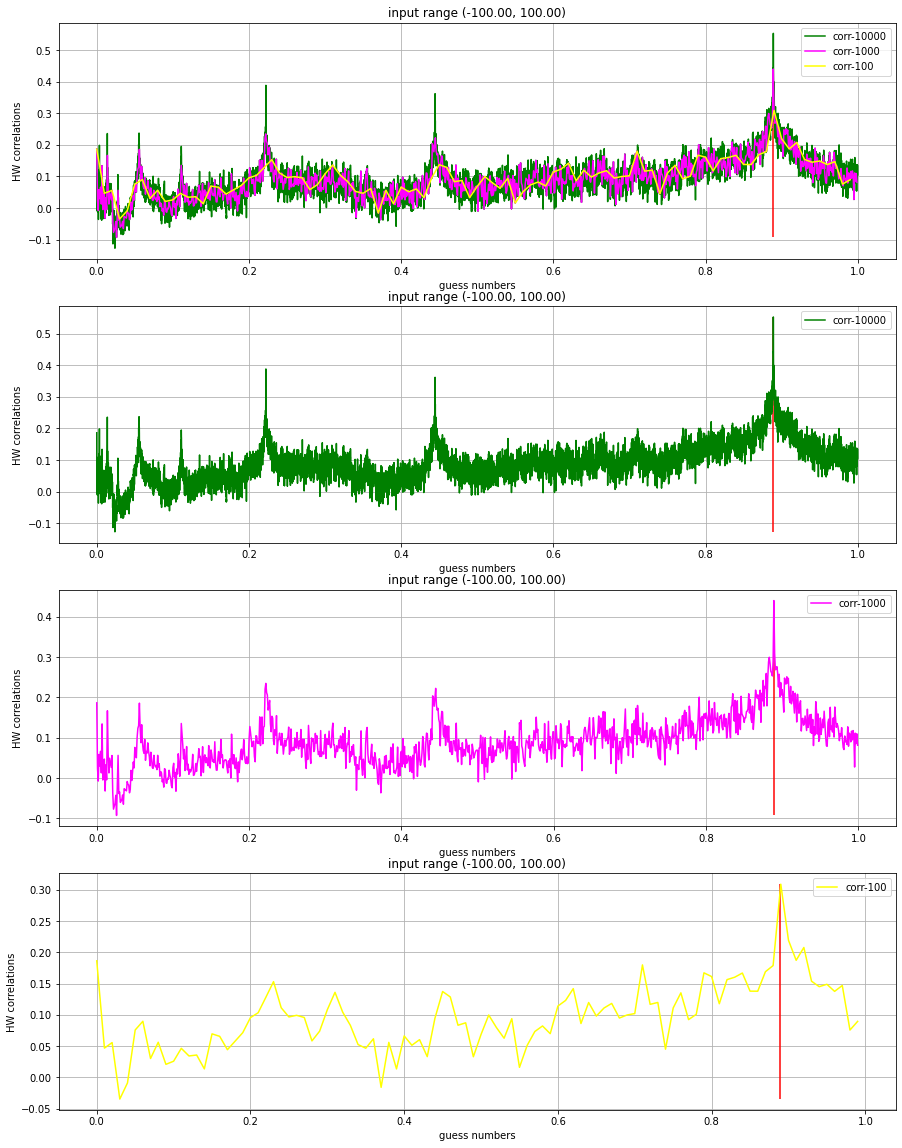

In [110]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantisa

In [111]:
mantisa_nbits = 10
two_powers = 1 / np.asarray([np.power(2.0, i) for i in np.arange(0, mantisa_nbits)])

def compute_mantisa(n):
    retval = 0.0
    s = "{0:b}".format(n)
    l = len(s)
    for idx in range(l):
        if s[l-idx-1] == '1':
            retval = retval + two_powers[idx]
    return retval

guess_numbers = np.vectorize(compute_mantisa)(np.arange(0, np.power(2, mantisa_nbits)))

In [112]:
def compute_corr_numbers(secret_hw, known_inputs, guess_numbers):
    hw = pd.DataFrame(columns=guess_numbers,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_numbers))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

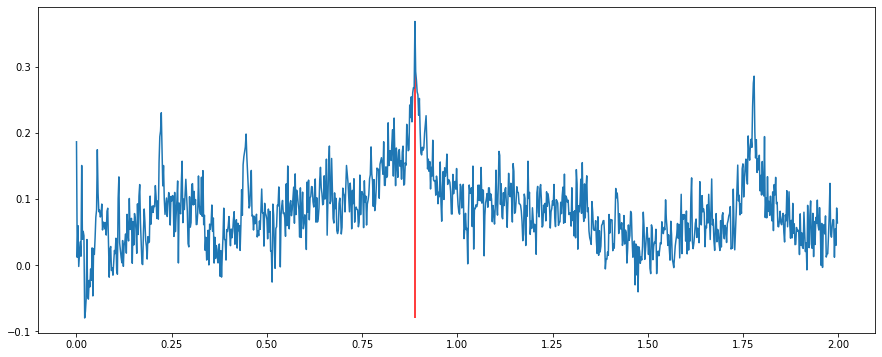

In [113]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [114]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

0.888672    0.368159
0.890625    0.292260
1.779297    0.285462
0.892578    0.279554
1.777344    0.275081
0.884766    0.268176
0.886719    0.267230
0.894531    0.261670
0.882812    0.260391
0.896484    0.257452
dtype: float64

## Correlation exponent

In [115]:
exponent_nbits = 8
exponents = np.arange(0, np.power(2.0, exponent_nbits)) - 127
two_exponents = np.vectorize(lambda x: np.power(2.0, x) if x >= 0 else 1.0/np.power(2.0, -x))(exponents)

In [116]:
guess_numbers = (np.asarray(mantisa_corr.sort_values(ascending=False).index[:10]) * two_exponents.reshape(-1, 1)).reshape(-1)
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


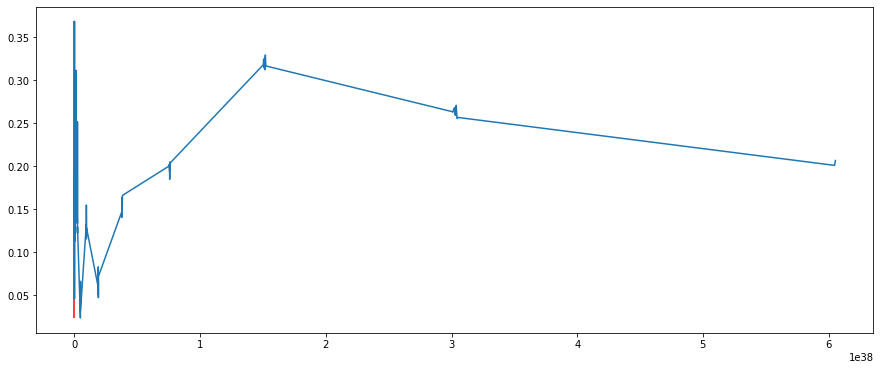

In [117]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [118]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

8.886719e-01    0.368159
8.886719e-01    0.368159
8.896484e-01    0.365686
4.817500e-20    0.355831
1.639310e+19    0.355831
1.639310e+19    0.355831
4.817500e-20    0.355831
1.641112e+19    0.354804
4.822794e-20    0.354804
3.821011e+09    0.342121
dtype: float64

## Analyze with noise - one number

In [148]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [149]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [150]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

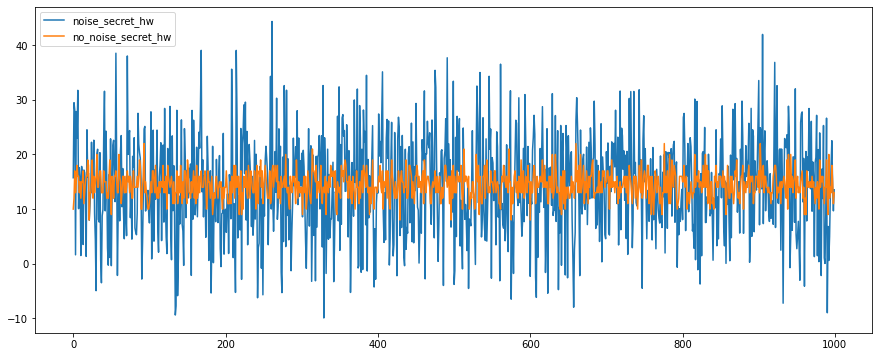

In [151]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=10)
ax = pd.DataFrame([noise_secret_hw, no_noise_secret_hw], index=['noise_secret_hw', 'no_noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [152]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.8890826472023605


3.570    0.132054
3.550    0.125484
3.555    0.112421
3.540    0.112093
0.885    0.110063
1.785    0.109203
1.775    0.100577
3.780    0.098206
3.505    0.096844
3.635    0.095094
dtype: float64

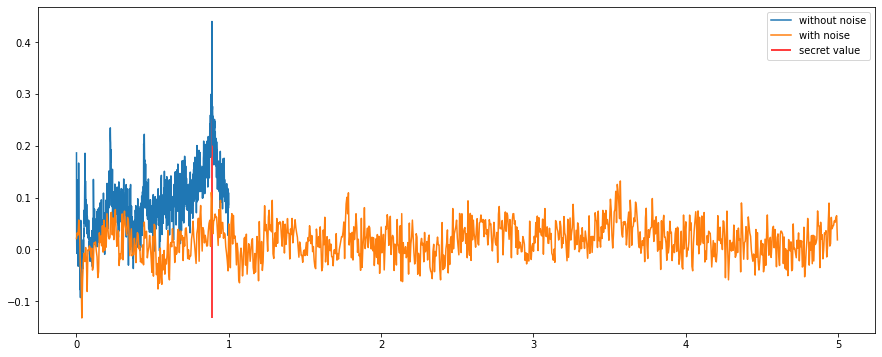

In [153]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [125]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [126]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [127]:
secret_numbers_hws[0]

,0.877142,0.280990,1.195570,2.287219,0.418791,1.995580,0.237539,3.725223,4.735708
0,16,16,22,20,13,19,13,19,18
1,17,17,23,19,19,19,16,23,19
2,21,18,21,17,15,20,19,12,18
3,19,18,20,14,19,19,17,17,16
4,20,14,16,22,13,19,15,14,14
...,...,...,...,...,...,...,...,...,...
495,17,18,16,17,19,20,15,16,18
496,17,18,18,17,20,20,17,10,11
497,18,16,16,16,19,22,16,19,20
498,15,21,19,21,19,20,17,12,15


In [128]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [129]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.877142] -2 0.877142 0.877143 0.999711'
'[0.877142] -1 0.877142 0.877143 0.998865'
'[0.877142] 00 1.754284 1.754285 0.969386'
'[0.877142] 01 0.877142 0.877143 0.999410'
'[0.877142] 02 3.508568 3.508569 0.957306'
'[0.877142] 03 0.877142 0.877143 0.998361'
'[0.280990] -2 4.495850 4.495850 0.770720'
'[0.280990] -1 4.495846 4.495847 0.983429'
'[0.280990] 00 4.495850 4.495851 0.620945'
'[0.280990] 01 0.280990 0.280991 0.997214'
'[0.280990] 02 0.280991 0.280991 0.822097'
'[0.280990] 03 0.280991 0.280991 0.755800'
'[1.195570] -2 4.782279 4.782280 0.922439'
'[1.195570] -1 4.782279 4.782280 0.980225'
'[1.195570] 00 4.782279 4.782280 0.681015'
'[1.195570] 01 1.195570 1.195570 0.999447'
'[1.195570] 02 4.782279 4.782280 0.960973'
'[1.195570] 03 1.195570 1.195570 0.999486'
'[2.287219] -2 2.287219 2.287220 0.999844'
'[2.287219] -1 2.287219 2.287220 0.999666'
'[2.287219] 00 2.287219 2.287220 0.999835'
'[2.287219] 01 2.287219 2.287220 0.999733'
'[2.287219] 02 2.287219 2.287220 1.000000'
'[2.287219]

In [154]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,0.877142,0.280990,1.195570,2.287219,0.418791,1.995580,0.237539,3.725223,4.735708
0,15.164075,14.397099,19.350180,22.449298,8.692740,21.051471,11.553590,17.718193,20.107443
1,17.679235,18.691397,21.298861,11.578717,17.755573,20.163347,16.721117,25.218922,18.407930
2,20.532446,19.552090,21.504112,12.738782,15.287416,18.719788,18.494412,13.711069,17.523014
3,17.272900,17.920390,17.117336,18.451138,17.053091,22.958240,17.030339,13.490562,17.493707
4,20.044406,14.659575,13.474652,24.277357,12.412178,18.229440,12.577607,14.306580,12.821177
...,...,...,...,...,...,...,...,...,...
495,16.778883,18.882651,18.294399,20.298915,18.240559,20.983665,15.022180,11.092916,15.019071
496,15.436693,19.091011,14.521400,14.550904,21.033332,22.663381,21.718549,10.716870,7.952848
497,15.929461,15.279136,17.563761,15.574437,18.607881,22.269313,20.559596,19.987792,20.091062
498,12.987967,20.563147,19.850187,20.052568,18.656954,17.545412,13.536998,13.866304,12.626384


In [155]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.877142] -2 0.877142 0.877143 0.811403'
'[0.877142] -1 3.508568 3.508569 0.740475'
'[0.877142] 00 3.508568 3.508569 0.526381'
'[0.877142] 01 0.877142 0.877143 0.806345'
'[0.877142] 02 1.754284 1.754285 0.709403'
'[0.877142] 03 0.877142 0.877143 0.757287'
'[0.280990] -2 4.495850 4.495850 0.657096'
'[0.280990] -1 4.495846 4.495847 0.718227'
'[0.280990] 00 4.495846 4.495847 0.578113'
'[0.280990] 01 0.280990 0.280991 0.791290'
'[0.280990] 02 4.495850 4.495850 0.592830'
'[0.280990] 03 4.495856 4.495857 0.610251'
'[1.195570] -2 4.782279 4.782280 0.732645'
'[1.195570] -1 4.782279 4.782280 0.763754'
'[1.195570] 00 1.195570 1.195570 0.719032'
'[1.195570] 01 1.195570 1.195570 0.771016'
'[1.195570] 02 4.782279 4.782280 0.786708'
'[1.195570] 03 1.195570 1.195570 0.791889'
'[2.287219] -2 2.287219 2.287220 0.807250'
'[2.287219] -1 2.287219 2.287220 0.768175'
'[2.287219] 00 2.287219 2.287220 0.813874'
'[2.287219] 01 2.287219 2.287220 0.769434'
'[2.287219] 02 2.287219 2.287220 0.759390'
'[2.287219]

### Statistics

In [156]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [157]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [158]:
noise_best_corr

,39,9,27,0,17,35,20,44,50
input id,1.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
low value,2.375382e-01,2.809900e-01,4.187906e-01,8.771420e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725222e+00,4.735708e+00
high value,2.375388e-01,2.809906e-01,4.187912e-01,8.771425e-01,1.195570e+00,1.995580e+00,2.287220e+00,3.725223e+00,4.735708e+00
correlation,8.084405e-01,7.912902e-01,8.224173e-01,8.114028e-01,7.918892e-01,7.831309e-01,8.138736e-01,8.421862e-01,8.275810e-01
secret value,2.375385e-01,2.809904e-01,4.187910e-01,8.771421e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725223e+00,4.735708e+00
guessed value,2.375385e-01,2.809903e-01,4.187909e-01,8.771423e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725223e+00,4.735708e+00
error,1.204508e-07,3.756292e-07,1.968505e-07,1.647326e-07,5.647905e-08,1.046404e-07,6.024092e-08,6.803447e-08,1.939154e-08


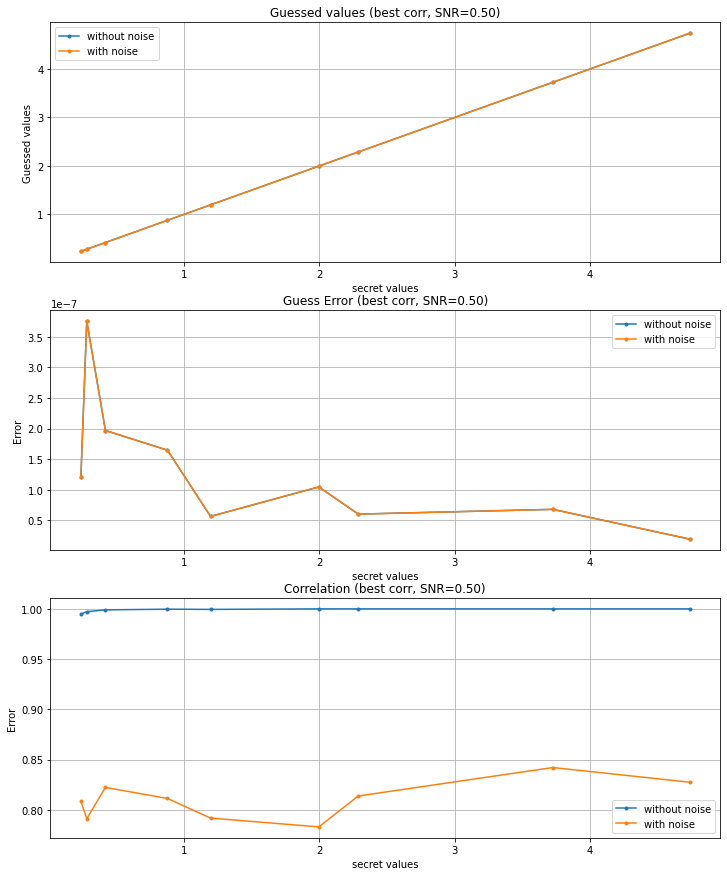

In [159]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

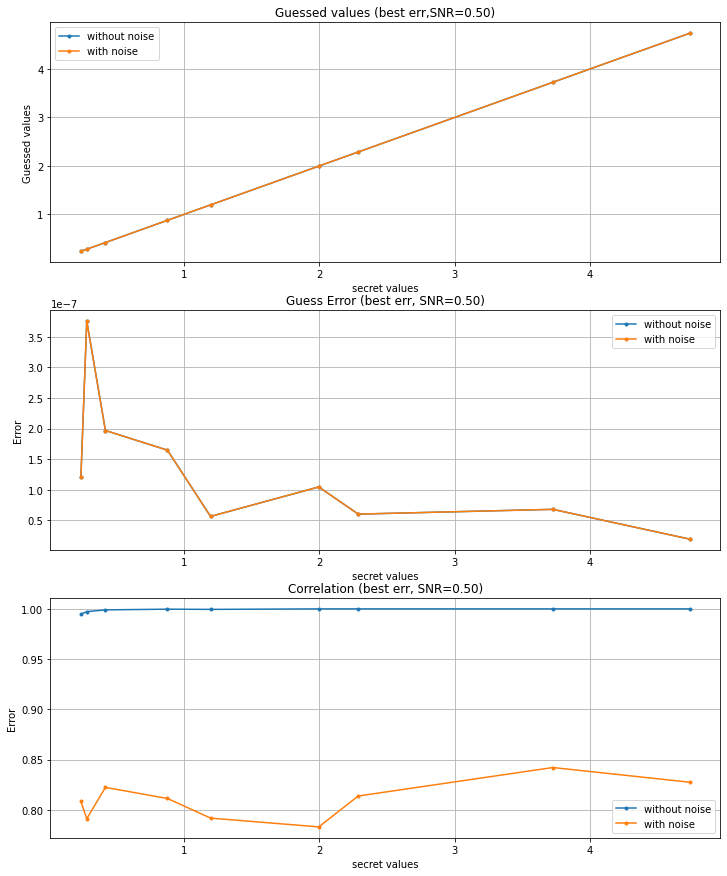

In [160]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [137]:
best_err

,37,9,24,0,15,30,18,42,48
input id,-1.000000e+00,1.000000e+00,-2.000000e+00,-2.000000e+00,1.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00
low value,2.375382e-01,2.809900e-01,4.187906e-01,8.771420e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725222e+00,4.735708e+00
high value,2.375388e-01,2.809906e-01,4.187912e-01,8.771425e-01,1.195570e+00,1.995580e+00,2.287220e+00,3.725223e+00,4.735708e+00
correlation,9.928195e-01,9.972143e-01,9.973904e-01,9.997109e-01,9.994469e-01,1.000000e+00,9.998440e-01,9.998326e-01,1.000000e+00
secret value,2.375385e-01,2.809904e-01,4.187910e-01,8.771421e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725223e+00,4.735708e+00
guessed value,2.375385e-01,2.809903e-01,4.187909e-01,8.771423e-01,1.195570e+00,1.995580e+00,2.287219e+00,3.725223e+00,4.735708e+00
error,1.204508e-07,3.756292e-07,1.968505e-07,1.647326e-07,5.647905e-08,1.046404e-07,6.024092e-08,6.803447e-08,1.939154e-08
